In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
from jax import random
import numpy as np
from jax import random, jit

from sgmcmcjax.samplers import build_sgld_sampler

from functools import partial

from jax.config import config
config.update("jax_debug_nans", True)

/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# define model in JAX
def loglikelihood(theta, x):
    print(x)
    print(jnp.shape(x))
    print(f'The type is {type(-0.5*jnp.dot(x-theta, x-theta))}')
    return -0.5*jnp.dot(x-theta, x-theta)

def logprior(theta):
    return -0.5*jnp.dot(theta, theta)*0.01

In [3]:
# generate dataset
N, D = 10000, 100
key = random.PRNGKey(0)
X_data = random.normal(key, shape=(N, D))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
print(np.shape(X_data))
print(type(X_data))

(10000, 100)
<class 'jaxlib.xla_extension.ArrayImpl'>


In [5]:
# build sampler
batch_size = int(0.1*N)
dt = 1e-5
my_sampler = build_sgld_sampler(dt, loglikelihood, logprior, (X_data,), batch_size)

# jit the sampler
#my_sampler = partial(jit, static_argnums=(1,))(my_sampler)

Traced<ShapedArray(float32[100])>with<BatchTrace(level=6/0)> with
  val = Traced<ShapedArray(float32[1000,100])>with<DynamicJaxprTrace(level=5/0)>
  batch_dim = 0
(100,)
The type is <class 'jax._src.interpreters.batching.BatchTracer'>


Running for 10,000 iterations: 100%|██████████| 10000/10000 [00:01<00:00, 8804.58it/s]


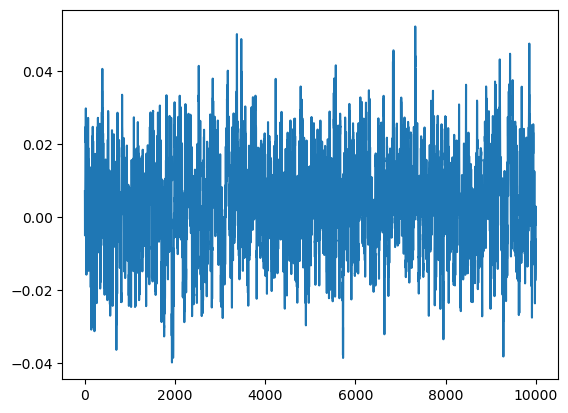

In [6]:
# run sampler
Nsamples = 10000
samples = my_sampler(key, Nsamples, jnp.zeros(D))

idx = 99
plt.plot(samples[:, idx])

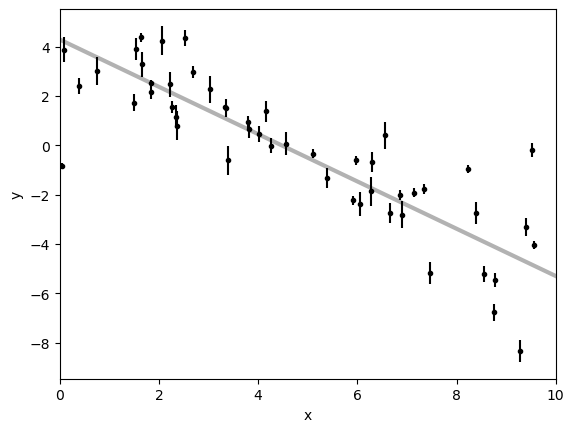

In [7]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [8]:
def log_prior(theta):
        m, b, log_f = theta
        return jnp.log(m*b*log_f)

def log_likelihood(theta, data):
    m, b, log_f = theta
    model = m * data[0] + b
    sigma2 = data[2]**2 + model**2 * jnp.exp(2 * log_f)
    output = -0.5 * jnp.sum((data[1] - model) ** 2 / sigma2 + jnp.log(sigma2))
    print(output)
    return output



In [9]:
# build sampler
batch_size = int(0.1 * N)
dt = 1e-5
data = jnp.array([x,y, yerr])
sampler = build_sgld_sampler(dt, log_likelihood, log_prior, (data, ), batch_size)

# jit the sampler
#sampler = partial(jit, static_argnums=(1,))(sampler)

In [10]:
initial_position = jnp.array([-1.0, 5.0, jnp.log(0.5)])

In [11]:
print(log_likelihood(initial_position, data))

-41.76017
-41.76017


In [12]:
# run sampler
Nsamples = 10_000
samples = sampler(key, Nsamples, jnp.zeros(3))

Traced<ShapedArray(float32[])>with<BatchTrace(level=6/0)> with
  val = Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=5/0)>
  batch_dim = 0


Running for 10,000 iterations: 100%|██████████| 10000/10000 [00:00<00:00, 940891.02it/s]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/jax/_src/pjit.py", line 1252, in _pjit_call_impl
    return compiled.unsafe_call(*args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/jax/_src/profiler.py", line 314, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/jax/_src/interpreters/pxla.py", line 1920, in __call__
    dispatch.check_special(self.name, arrays)
  File "/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/jax/_src/dispatch.py", line 436, in check_special
    _check_special(name, buf.dtype, buf)
  File "/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/jax/_src/dispatch.py", line 441, in _check_special
    raise FloatingPointError(f"invalid v

In [ ]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

idx = 1
plt.plot(np.array(samples)[:, idx])
plt.axhline(4.294, c='r')
plt.show()